In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

data_folder = '/content/drive/MyDrive/2months_data'
all_files = os.listdir(data_folder)
csv_files = [os.path.join(data_folder, f) for f in all_files if f.endswith('.csv')]

def read_csv_file(file_path):
    encodings = ['utf-8', 'cp949', 'euc-kr']  # List of possible encodings
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except (UnicodeDecodeError, pd.errors.EmptyDataError, pd.errors.ParserError):
            continue
    raise ValueError(f"Could not read file {file_path} with any encoding.")

valid_dataframes = []
for file in csv_files:
    try:
        df = read_csv_file(file)
        if not df.empty:
          valid_dataframes.append(df)
    except ValueError as e:
        print(e)

if valid_dataframes:
    combined_data = pd.concat(valid_dataframes, ignore_index=True)
else:
    combined_data = pd.DataFrame()
combined_data.columns=["Creation date", "load factor", "Set Pressure", "Boiler Pressure",
                      "Blower Inverter Output", "Blower Input", "Water Supply Pump",
                      "Water Supply Pump Input", "Gas Damper", "Gas Damper Input",
                      "Air Damper", "Air Damper Input", "Recirculation Damper",
                      "Recirculation External Damper", "Recirculation Damper Input",
                      "Recirculation External Damper Input", "Water Supply Level",
                      "Boiler Temperature", "Exhaust Gas Temperature 1",
                      "Exhaust Gas Temperature 2", "Exhaust Gas Temperature 3",
                      "Exhaust Recirculation Temperature", "Economizer Temperature 1",
                      "Economizer Temperature 2", "Burner Temperature", "Exhaust Gas NOx",
                      "Exhaust Gas O2", "Recirculation O2", "Recirculation NOx",
                      "Water Supply Amount (Cumulative Flow)",
                      "Water Supply Amount (Instantaneous Flow)",
                      "Fuel Amount (Cumulative Flow)", "Fuel Amount (Instantaneous Flow)",
                      "Efficiency (Instantaneous)", "Power Consumption", "Vibration Sensor 1",
                      "Vibration Sensor 2", "Operating Time", "Normal Operation Probability",
                      "Blower Failure Probability", "Air Damper Failure Probability",
                      "Gas Damper Failure Probability", "Probability Update Time",
                      "Instantaneous Steam Amount", "Input-Output Efficiency",
                      "Heat Loss Efficiency", "Efficiency (input/output method-steam)"]
combined_data = combined_data.drop(columns=[
    "Creation date","Power Consumption","Vibration Sensor 1","Vibration Sensor 2","Operating Time",
    "Normal Operation Probability","Blower Failure Probability","Air Damper Failure Probability",
    "Gas Damper Failure Probability","Probability Update Time","Instantaneous Steam Amount",
    "Input-Output Efficiency","Heat Loss Efficiency","Efficiency (input/output method-steam)",
    "Exhaust Recirculation Temperature","Burner Temperature"
])

scaler = StandardScaler()
numeric_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns
combined_data[numeric_columns] = scaler.fit_transform(combined_data[numeric_columns])

# Select numerical columns only
numerical_columns = combined_data.select_dtypes(include=['float64', 'int64']).columns

# Fill missing values in numerical columns with the mean value
combined_data[numerical_columns] = combined_data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# For categorical columns, fill missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
combined_data[combined_data.select_dtypes(include=['object']).columns] = cat_imputer.fit_transform(combined_data.select_dtypes(include=['object']))

# Encode categorical variables (if any)
label_encoder = LabelEncoder()
for column in combined_data.select_dtypes(include=['object']).columns:
    combined_data[column] = label_encoder.fit_transform(combined_data[column])

combined_data.to_csv('/content/drive/MyDrive/preprocessed_boiler_data.csv', index=False, encoding='utf-8')

Missing values per column:
 Creation date                               0
load factor                                 0
Set Pressure                                0
Boiler Pressure                             0
Blower Inverter Output                      0
Blower Input                                0
Water Supply Pump                           0
Water Supply Pump Input                     0
Gas Damper                                  0
Gas Damper Input                            0
Air Damper                                  0
Air Damper Input                            0
Recirculation External Air Damper           0
Recirculation Damper Input                  0
Recirculation External Damper               0
Recirculation Damper Input.1                0
Recirculation External Damper Input         0
Water Supply Level                          0
Boiler Temperature                          0
Exhaust Gas Temperature 1                   0
Exhaust Gas Temperature 2                   0
Exhaus

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# combined_data = 전처리된 데이터프레임 (전처리 코드는 이미 실행된 상태라고 가정)

# 독립 변수(X)와 종속 변수(y) 설정
X = combined_data.drop(columns=['Efficiency (Instantaneous)'])  # 종속 변수 제외
y = combined_data['Efficiency (Instantaneous)']

# 데이터 분할: 훈련 데이터와 테스트 데이터로 분할
# 여기에서 train_test_split을 사용하여 X_train, X_test, y_train, y_test를 생성
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 예시: 80% 훈련, 20% 테스트

# Random Forest Model with RandomizedSearchCV for hyperparameter tuning
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [None, 10, 15, 20, 25],           # Maximum depth of the tree
    'min_samples_split': [2,5,10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,4],    # Minimum number of samples required to be at a leaf node
    'max_features':['sqrt', 'log2'],  # Number of features to consider at each split
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2]  # 리프 노드의 가중치 샘플 최소값
}

# Randomized Search CV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=50, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# Model evaluation using test data
y_pred = random_search.predict(X_test)

# Calculate performance metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
mse = np.mean((y_test - y_pred) ** 2)

print(f"MAPE: {mape:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


테스트 데이터 MSE: 0.1096119830842734
테스트 데이터 MAE: 0.047545400803989106
테스트 데이터 RMSE: 0.3310770047651655
테스트 데이터 MAPE: 45.38%


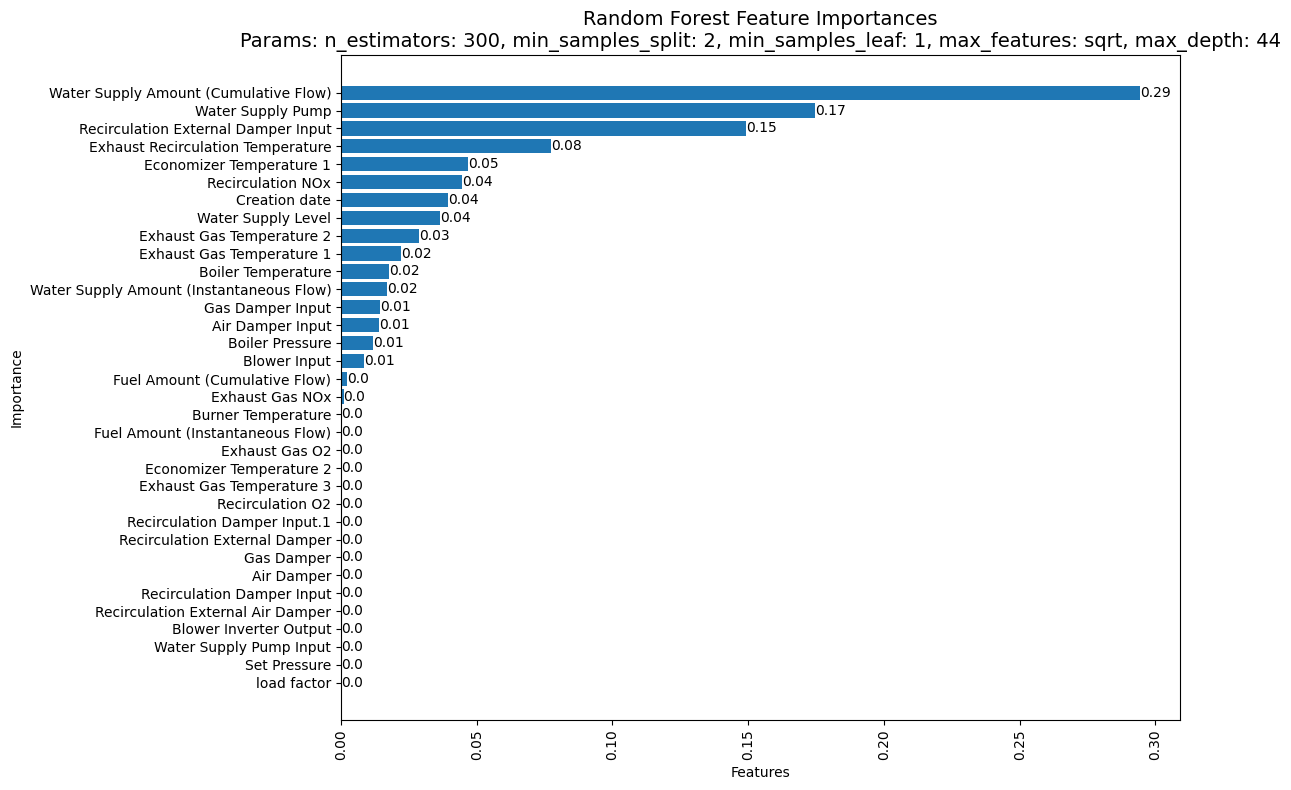

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import shutil

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# 예시 데이터 (random_search.best_estimator_는 미리 학습된 상태여야 함)
feature_importances = random_search.best_estimator_.feature_importances_
features = X.columns  # 각 피처의 이름

# 피처 중요도를 시리즈로 변환하고, 중요도 순서대로 정렬
feature_importance_series = pd.Series(feature_importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=feature_importance_series, y=feature_importance_series.index)

# 각 바에 중요도 값을 텍스트로 표시
for i, (value, name) in enumerate(zip(feature_importance_series, feature_importance_series.index)):
    ax.text(value, i, f'{value:.4f}', va='center', ha='left', fontsize=10, color='black')

plt.title('Feature Importance from Random Forest Model (with values)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [15]:
from scipy.optimize import minimize

def predict_efficiency(params):
    params = np.array(params).reshape(1, -1)
    efficiency = random_search2.best_estimator_.predict(params)
    return efficiency[0]

def loss_function(params):
    return -predict_efficiency(params)

initial_params = np.random.rand(16)

result = minimize(loss_function, initial_params, method='BFGS')

optimized_params = result.x
optimized_efficiency = -result.fun

print("최적화된 인자:", optimized_params)
print("최적화된 보일러 효율:", optimized_efficiency)

최적화된 인자: [0.04273369 0.83547064 0.07701645 0.55767253 0.59031355 0.40224536
 0.11247933 0.52119182 0.55151734 0.97103125 0.62040213 0.8209904
 0.67618543 0.10579766 0.59420898 0.47875498]
최적화된 보일러 효율: 0.00017415536007770079


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does